# Table of Contents
- [STATIONARITY & TRANSFORMATIONS](#stationarity--transformations)
   - [Data Cleaning](#data-cleaning)
     - [Missing Values](#missing-values)
     - [Outliers](#outliers)
   - [STATIONARITY](#STATIONARITY)
     - [ACF and PACF functions](#acf-and-pacf-functions)


In [16]:
# import packages   
import os
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# STATIONARITY & TRANSFROMATIONS

## Data Cleaning

Clean the data of outliers or breaks

### Missing Values

In [17]:
# Load data
os.chdir('.')  # Set working directory to your file's location
df = pd.read_csv('data_Naseh.csv')

# Rename columns
df.columns = ['date', 'y']

# Convert 'date' column to datetime and check its data type
df['date'] = pd.to_datetime(df['date'])
print("Data types after converting 'date':\n", df.dtypes)
print("-"*50)

# Remove time part (hour:min:sec) from 'date' column
df['date'] = df['date'].dt.date
print("Data types after removing time part from 'date':\n", df.dtypes)
print("-"*50)

# Convert 'y' column to numeric and check its data type
df['y'] = pd.to_numeric(df['y'], errors='coerce')
print("Data types after converting 'y' to numeric:\n", df.dtypes)
print("-"*50)

Data types after converting 'date':
 date    datetime64[ns]
y               object
dtype: object
--------------------------------------------------
Data types after removing time part from 'date':
 date    object
y       object
dtype: object
--------------------------------------------------
Data types after converting 'y' to numeric:
 date     object
y       float64
dtype: object
--------------------------------------------------


In [18]:
# Check for missing values
print("Missing values:\n", df.isna().sum())

# Fill missing values in 'y' using a moving average with a specified window size
window_size = 5
df['y'] = df['y'].fillna(df['y'].rolling(window=window_size, min_periods=1).mean())

# Verify that missing values are filled
print("Missing values after Moving Average:\n", df.isna().sum())

Missing values:
 date      0
y       267
dtype: int64
Missing values after Moving Average:
 date    0
y       0
dtype: int64


We can replace each missing point with the average of the rolling window around it.
this code effectively addresses breaks by identifying missing values in the y column and then filling these breaks with a smoothed estimate (moving average), thus maintaining continuity in the time series data.

### Outliers

In [19]:
# IQR Method
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
df['outlier_iqr'] = ((df['y'] < (Q1 - 1.5 * IQR)) | (df['y'] > (Q3 + 1.5 * IQR)))

In [20]:
df['outlier_iqr']

0       False
1       False
2       False
3       False
4       False
        ...  
9749    False
9750    False
9751    False
9752    False
9753    False
Name: outlier_iqr, Length: 9754, dtype: bool

## STATIONARITY

Decide and describe whether the series is stationary or not. upport your argument with ACF and PACF functions, as well as statistical tests.

### ACF and PACF functions

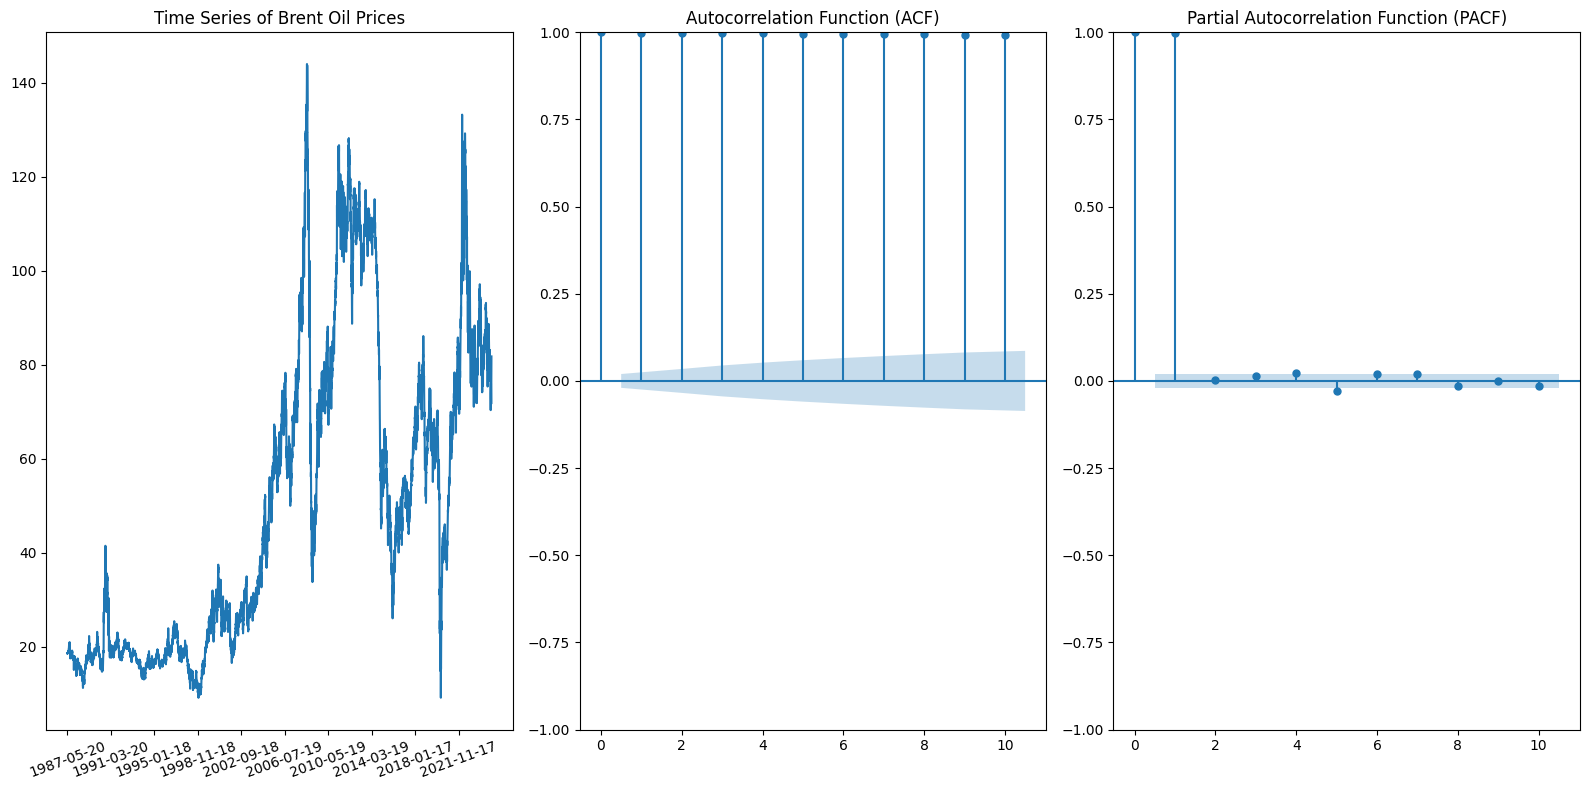

In [21]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

# Plot the 'y' column (oil prices over time)
n_tick = 1000  # Number of ticks to display
axs[0].plot(df.y)

# Set x-ticks and x-tick labels
xticks = np.arange(0, len(df.y), n_tick)
axs[0].set_xticks(xticks)

# Ensure that the number of labels matches the number of ticks
xtick_labels = df.date.iloc[xticks].astype(str)  # Convert dates to strings for labeling
axs[0].set_xticklabels(xtick_labels, rotation=20)

# Set title for the first plot
axs[0].set_title('Time Series of Brent Oil Prices')

# Plot the autocorrelation function (ACF) and partial autocorrelation function (PACF)
sm.graphics.tsa.plot_acf(df.y, lags=10, ax=axs[1])
axs[1].set_title('Autocorrelation Function (ACF)')

sm.graphics.tsa.plot_pacf(df.y, lags=10, ax=axs[2])
axs[2].set_title('Partial Autocorrelation Function (PACF)')

# Adjust layout to avoid overlapping elements
plt.tight_layout()

# Show the plots
plt.show()

- **Time Series Plot:**
The time series shows clear upward and downward trends over different periods, along with noticeable peaks and troughs.
This suggests non-stationarity, as the series does not have a constant mean or variance over time.

- **Autocorrelation Function (ACF) Plot:**
The ACF plot shows significant autocorrelation at multiple lags, with slow decay. This is typical for non-stationary series, as the values are highly correlated with previous values.
Slow decay in the ACF indicates a trend or persistence over time, which reinforces the likelihood of non-stationarity.

- **Partial Autocorrelation Function (PACF) Plot:**
The PACF shows a high value at the first lag and then drops off significantly.
This pattern can sometimes suggest that the series may become stationary after differencing once, as a single significant PACF lag indicates a potential AR(1) process in a differenced series.

this series appears to be non-stationary and to make it stationary, we will apply first-order differencing. This transformation can often remove trends and stabilize the mean.
